In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [4]:
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions_'
result_dir='/home/garg/data/WeatherBench/tmp'
# # model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
# # datadir='/data/stephan/WeatherBench/5.625deg/'
# # pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'

In [5]:
!ls {result_dir}

categorical_crps.nc	      dropout_mae.nc		 preds_cat_ens.nc
categorical_quantile_rmse.nc  dropout_ranks.pkl		 preds_param_ztt_ens.nc
categorical_ranks.pkl	      dropout_rmse.nc		 tigge_crps.nc
categorical_rmse.nc	      dropout_spreadskill.nc	 tigge_ranks.pkl
categorical_spreadskill.nc    parametric_crps.nc	 tigge_rmse.nc
dropout_crps.nc		      parametric_ranks.pkl	 tigge_spreadskill.nc
dropout_det_mae.nc	      parametric_rmse.nc
dropout_det_rmse.nc	      parametric_spreadskill.nc


## Data

In [6]:
!ls {datadir}

2017_2018_subset.zip	  geopotential	     toa_incident_solar_radiation
2m_temperature		  geopotential_500   u_component_of_wind
6hr_precipitation	  specific_humidity  v_component_of_wind
backup_specific_humidity  temperature
constants		  temperature_850


In [7]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

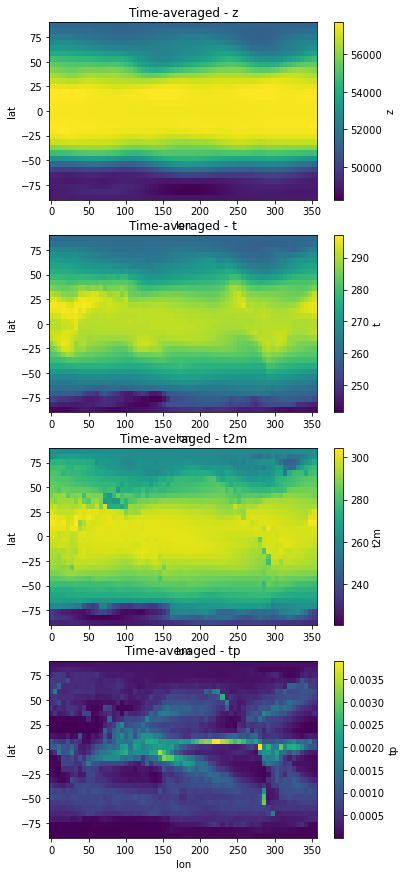

In [46]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].mean('time').plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged - {v}')

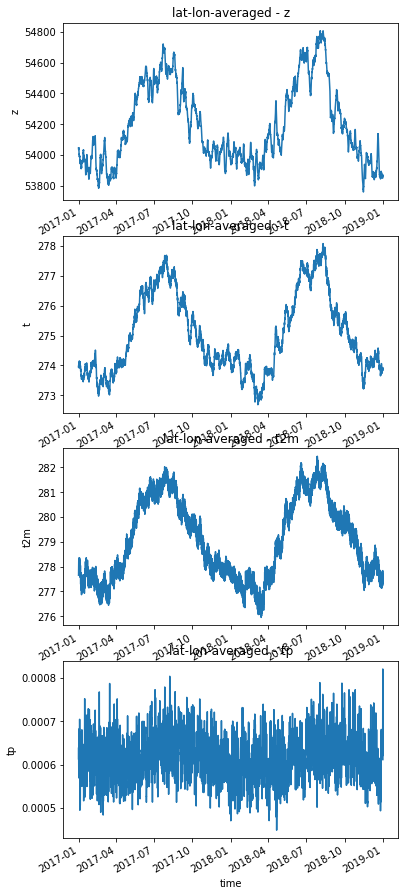

In [59]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].mean({'lat','lon'}).plot(ax=axs[j])
    axs[j].set_title(f'lat-lon-averaged - {v}')

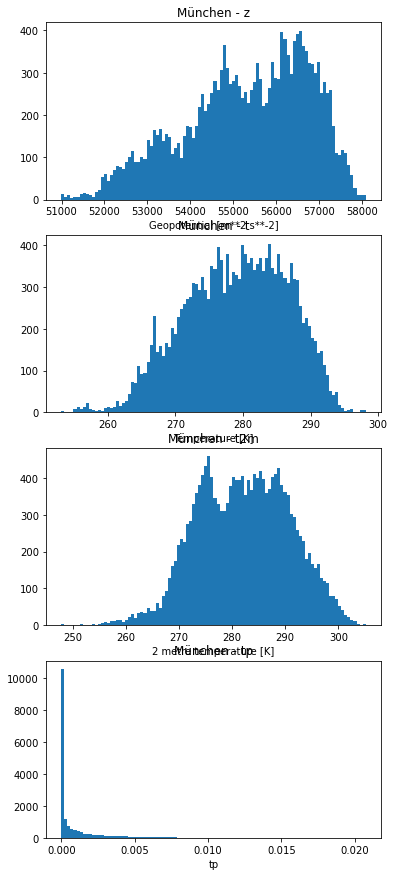

In [25]:
#München: 48.1351, 11.5820
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].sel(lat=48.1351, lon=11.5820, method='nearest').plot.hist(ax=axs[j], bins=100)
    axs[j].set_title(f'München - {v}')

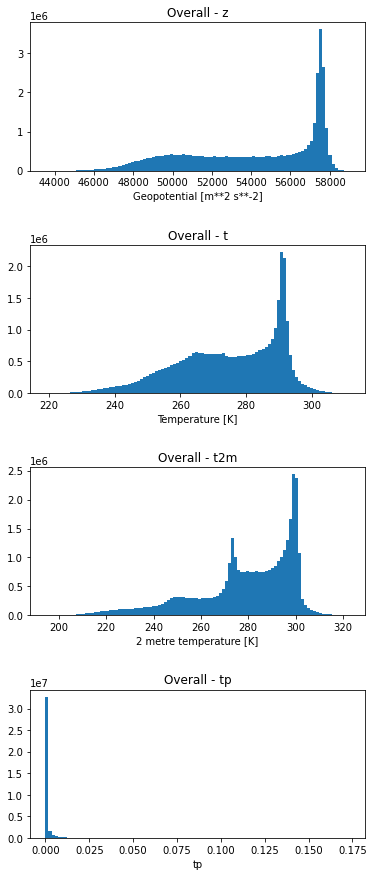

In [34]:
#Flattened
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
fig.subplots_adjust(hspace=0.5)
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    valid[v].plot.hist(ax=axs[j], bins=100)
    axs[j].set_title(f'Overall - {v}')

# Predictions

# Scores

## Dropout

In [76]:
dropout_det_rmse=xr.open_dataset(f'{result_dir}/dropout_det_rmse.nc')
dropout_mc_rmse=xr.open_dataset(f'{result_dir}/dropout_rmse.nc')

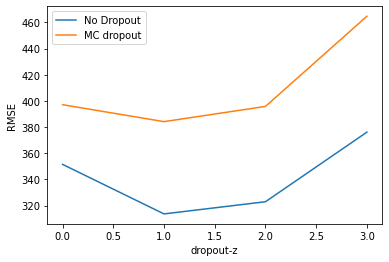

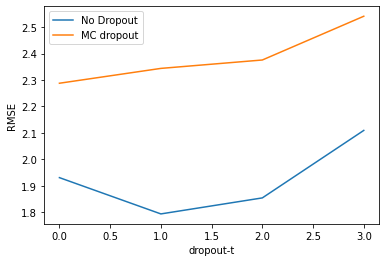

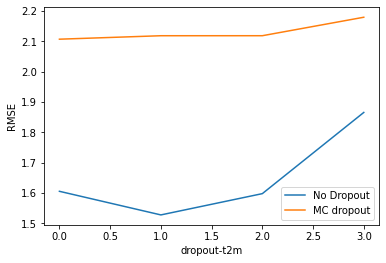

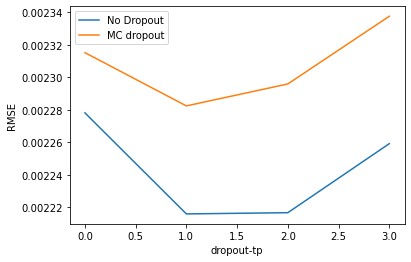

In [77]:
for v in ['z','t','t2m','tp']:
    fig, ax = plt.subplots()
    ax.plot(dropout_det_rmse[v], label='No Dropout')
    ax.plot(dropout_mc_rmse[v], label='MC dropout')
    ax.set_xlabel(f'dropout-{v}')
    ax.set_ylabel('RMSE')
#ax.set_title("Simple Plot")
    ax.legend()

In [34]:
dropout_det_mae=xr.open_dataset(f'{result_dir}/dropout_det_mae.nc')
dropout_mc_mae=xr.open_dataset(f'{result_dir}/dropout_mae.nc')
dropout_mc_crps=xr.open_dataset(f'{result_dir}/dropout_crps.nc')

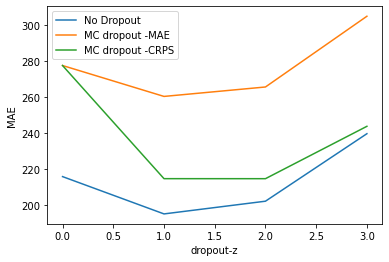

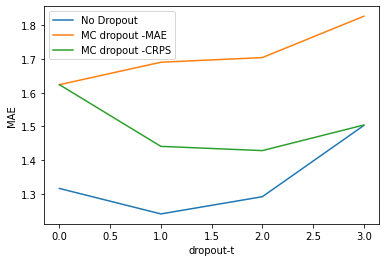

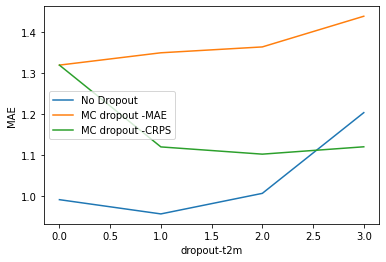

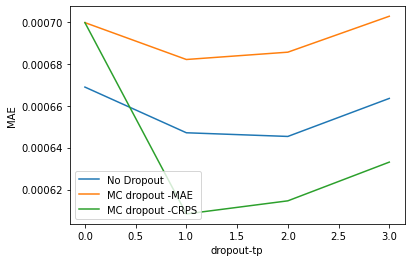

In [45]:


for v in ['z','t','t2m','tp']:
    fig, ax = plt.subplots()
    ax.plot(dropout_det_mae[v], label='No Dropout')
    ax.plot(dropout_mc_mae[v], label='MC dropout -MAE')
    ax.plot(dropout_mc_crps[v], label='MC dropout -CRPS')
    ax.set_xlabel(f'dropout-{v}')
    ax.set_ylabel('MAE')
#ax.set_title("Simple Plot")
    ax.legend()

In [ ]:
#Why is deterministic forecast better performing (both RMSE, CRPS) than MC. Is it the same network?

In [36]:
dropout_mc_ss=xr.open_dataset(f'{result_dir}/dropout_spreadskill.nc')

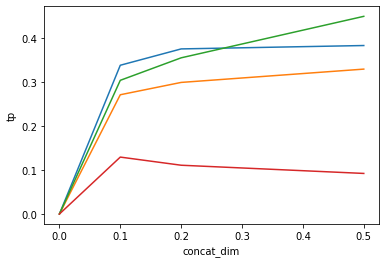

In [47]:
for v in ['z','t','t2m','tp']:
    dropout_mc_ss[v].plot()

In [ ]:
#Considering dr=0.1 from now on, since best among all MC.

In [7]:
!ls {result_dir}

categorical_crps.nc	      dropout_det_rmse.nc     parametric_rmse.nc
categorical_quantile_rmse.nc  dropout_mae.nc	      parametric_spreadskill.nc
categorical_ranks.pkl	      dropout_ranks.pkl       preds_cat_ens.nc
categorical_rmse.nc	      dropout_rmse.nc	      preds_param_ztt_ens.nc
categorical_spreadskill.nc    dropout_spreadskill.nc  tigge_ranks.pkl
dropout_crps.nc		      parametric_crps.nc
dropout_det_mae.nc	      parametric_ranks.pkl


## RMSEs

In [28]:
for var in ['dropout','parametric','categorical','tigge']:
    var=xr.open_dataset(f'{result_dir}/{var}_rmse.nc')

In [60]:
tigge

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, member: 50, time: 1454)
Coordinates:
    step               timedelta64[ns] 3 days
  * time               (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
  * lat                (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
    valid_time         (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
  * lon                (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * member             (member) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>
    t                  (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>
    t2m                (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>

In [61]:
rmses=xr.merge([dropout.sel(concat_dim=0.0),
                dropout.sel(concat_dim=0.1),
                dropout.sel(concat_dim=0.2),
                dropout.sel(concat_dim=0.5)
                ,parametric,categorical], compat='override')

In [62]:
rmses

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    concat_dim  float64 0.0
Data variables:
    t           float64 2.288
    t2m         float64 2.107
    z           float64 397.1
    tp          float64 0.002315

## Spreadskill

## CRPS

## Rank Histograms

In [67]:
!ls {result_dir}

categorical_crps.nc	      dropout_mae.nc		 preds_cat_ens.nc
categorical_quantile_rmse.nc  dropout_ranks.pkl		 preds_param_ztt_ens.nc
categorical_ranks.pkl	      dropout_rmse.nc		 tigge_crps.nc
categorical_rmse.nc	      dropout_spreadskill.nc	 tigge_ranks.pkl
categorical_spreadskill.nc    parametric_crps.nc	 tigge_rmse.nc
dropout_crps.nc		      parametric_ranks.pkl	 tigge_spreadskill.nc
dropout_det_mae.nc	      parametric_rmse.nc
dropout_det_rmse.nc	      parametric_spreadskill.nc


In [70]:
with open(f'/home/garg/data/WeatherBench/tmp/dropout_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

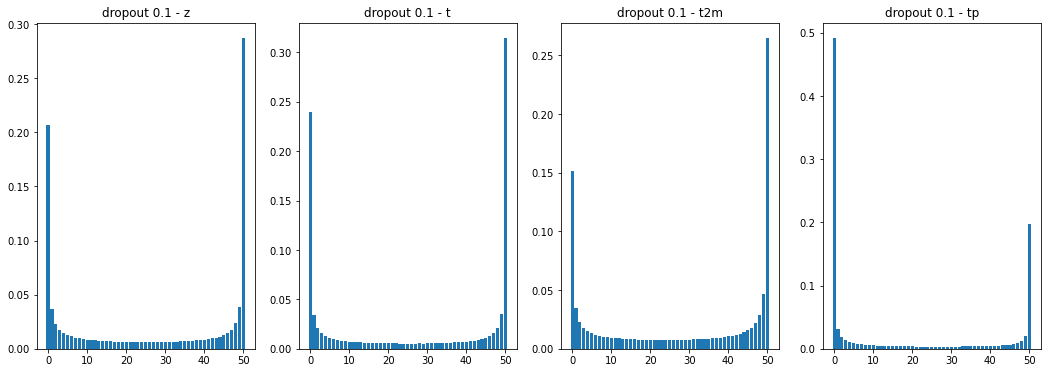

In [73]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.1][v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'dropout 0.1 - {v}')

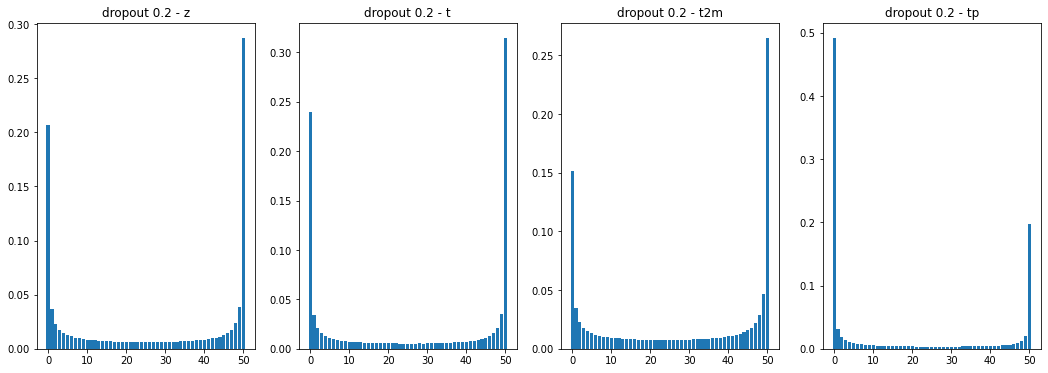

In [74]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.1][v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'dropout 0.2 - {v}')

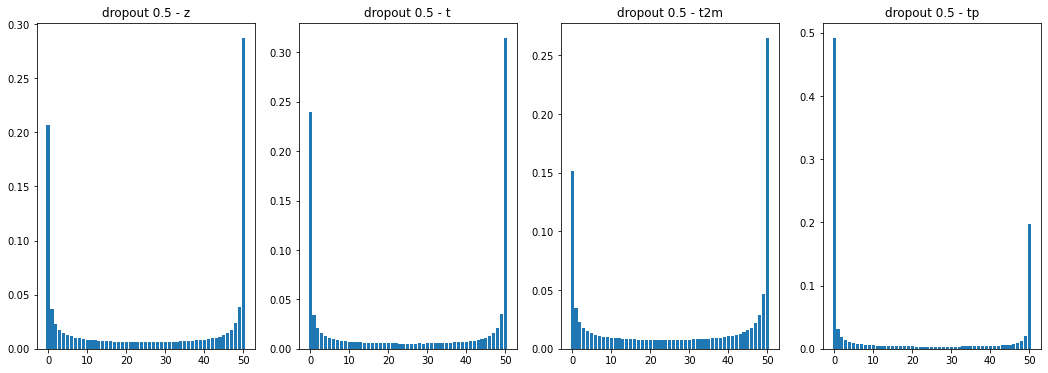

In [75]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[0.1][v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'dropout 0.5 - {v}')

In [56]:
with open(f'/home/garg/data/WeatherBench/tmp/categorical_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

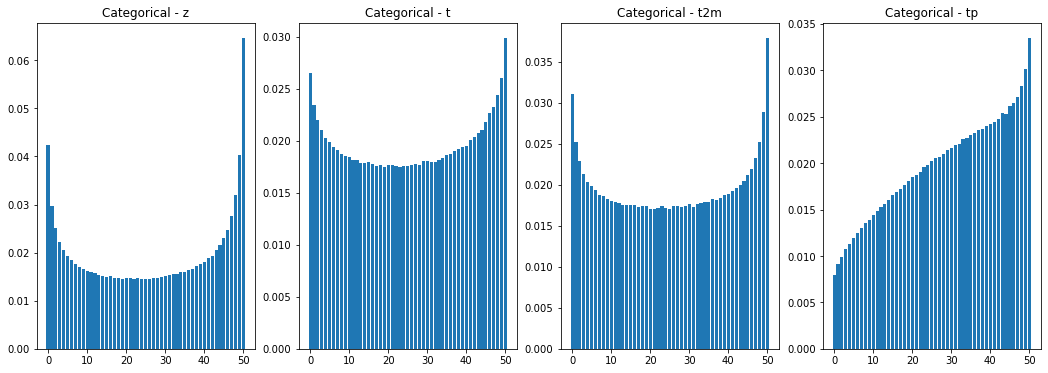

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Categorical - {v}')

In [ ]:
#categorical tp better than z,t,t2m?

In [40]:
with open(f'/home/garg/data/WeatherBench/tmp/parametric_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

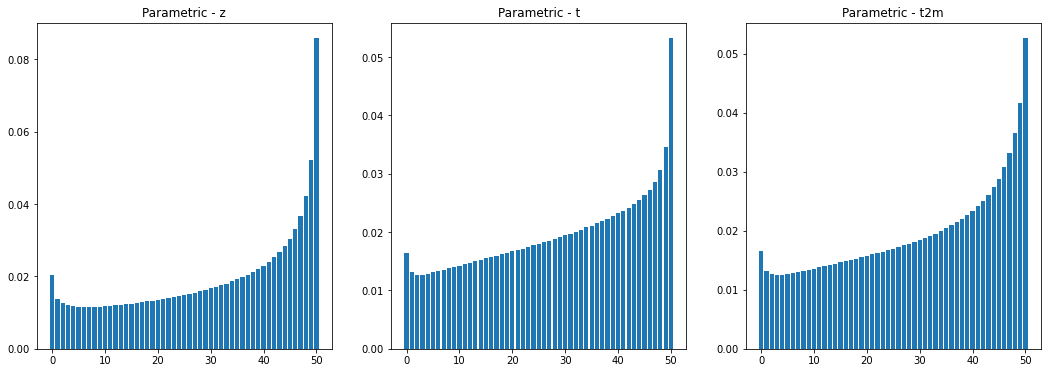

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

In [43]:
with open(f'/home/garg/data/WeatherBench/tmp/tigge_ranks.pkl', 'rb') as f:
    ranks= pickle.load(f)

EOFError: Ran out of input

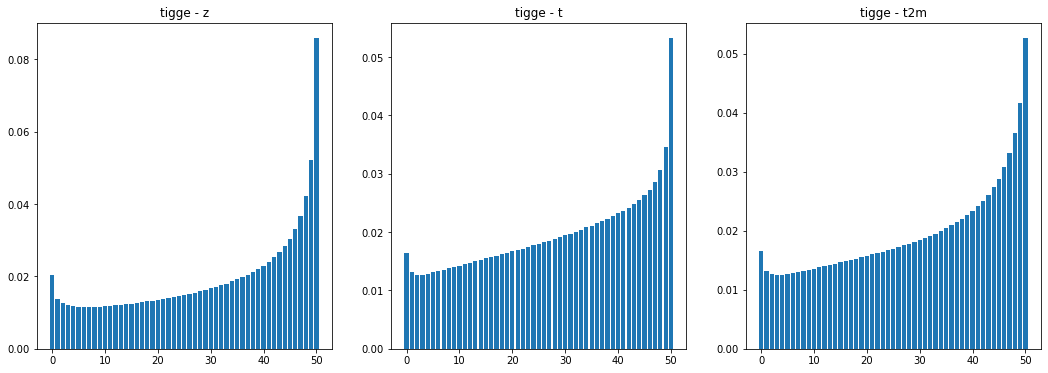

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'tigge - {v}')

In [ ]:
#Note: Categorical has been trained separetely for z, t, t2m, tp. 
#So has ~3 times more parameters than parametric, 
#still comparable performance b/w the two.


In [ ]:
#right bias (underforecasting): my guess is it is predicting zeroes mostly for precipitation
#but what about others